In [1]:
import cimpy
from cimpy import CIM2DPsim
from cimpy.CIM2DPsim import Domain
from cimpy.cgmes_v2_4_15.Base import short_profile_name
import os
from pathlib import Path

import sys
sys.path.insert(0,'/home/mmo/git/Can/dpsim/build')
import dpsimpy

example_dir = Path(os.path.join('../cimpy/examples/sampledata/IEEE14')).resolve()

test_files = []
for file in example_dir.glob('*.xml'):
    test_files.append(str(file.absolute()))

imported_result = cimpy.cim_import(test_files, 'cgmes_v2_4_15')

CIM object Diagram created : 1 times
CIM object DiagramObjectPoint created : 168 times
CIM object DiagramObject created : 77 times
CIM object SvPowerFlow created : 16 times
CIM object SvVoltage created : 14 times
CIM object SvTapStep created : 5 times
CIM object TopologicalIsland created : 1 times
CIM object TopologicalNode created : 14 times
CIM object VoltageLimit created : 14 times
CIM object Terminal created : 58 times
CIM object VoltageLevel created : 14 times
CIM object OperationalLimitSet created : 56 times
CIM object PowerTransformer created : 5 times
CIM object ConformLoad created : 11 times
CIM object SubGeographicalRegion created : 1 times
CIM object RegulatingControl created : 5 times
CIM object BaseVoltage created : 4 times
CIM object PowerTransformerEnd created : 10 times
CIM object CurrentLimit created : 42 times
CIM object LoadArea created : 1 times
CIM object ConformLoadGroup created : 1 times
CIM object OperationalLimitType created : 2 times
CIM object RatioTapChanger

### Run Powerflow Simulation

In [2]:
name_pf = "IEEE14_ReaderTest_PF"
dpsimpy.Logger.set_log_dir("logs/" + name_pf)

# create dpsim topology from cimpy object
system_PF = CIM2DPsim.CIM2DPsim(imported_result, Domain.PF, log_level=dpsimpy.LogLevel.info)

#set slack
system_PF.component("Gen_0001").modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

sim_pf = dpsimpy.Simulation(name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_PF)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
#sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.do_init_from_nodes_and_terminals(False)

logger = dpsimpy.Logger(name_pf)
sim_pf.add_logger(logger)
for node in system_PF.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)
    
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.5)
sim_pf.run()

[19:30:48.600256 IEEE14_ReaderTest_PF info] Initialize simulation: IEEE14_ReaderTest_PF
[19:30:48.601151 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0010
[19:30:48.601163 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0014
[19:30:48.601170 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0011
[19:30:48.601177 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0002
[19:30:48.601200 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0012
[19:30:48.601207 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0003
[19:30:48.601213 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0013
[19:30:48.601825 IEEE14_ReaderTest_PF info] Scheduling tasks.
[19:30:48.602456 IEEE14_ReaderTest_PF info] Scheduling done.
[19:30:48.602460 IEEE14_ReaderTest_PF info] Opening interfaces.
[19:30:48.602461 IEEE14_ReaderTest_PF info] Start syn

### Read of results

In [3]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt

dpsim_result_file = 'logs/' + name_pf + '/' + name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

column number: 28
results length: 6
real column names: []
complex column names: ['Bus_0001.S', 'Bus_0001.V', 'Bus_0002.S', 'Bus_0002.V', 'Bus_0003.S', 'Bus_0003.V', 'Bus_0004.S', 'Bus_0004.V', 'Bus_0005.S', 'Bus_0005.V', 'Bus_0006.S', 'Bus_0006.V', 'Bus_0007.S', 'Bus_0007.V', 'Bus_0008.S', 'Bus_0008.V', 'Bus_0009.S', 'Bus_0009.V', 'Bus_0010.S', 'Bus_0010.V', 'Bus_0011.S', 'Bus_0011.V', 'Bus_0012.S', 'Bus_0012.V', 'Bus_0013.S', 'Bus_0013.V', 'Bus_0014.S', 'Bus_0014.V']


In [4]:
dpsim_results = pd.DataFrame(columns=['Bus', 'Vmag [kV]', 'Vangle [rad]', 'P [MW]', 'Q [MVAr]'])
base_power = 100 #mw
for i in range(len(system_PF.nodes)):
    node_name = system_PF.nodes[i].name()
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / 1000, 4)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1]), 4)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]), 4)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]), 5)])

dpsim_results



,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,1.0452,-0.2349,-0.0000,0.00000
1,Bus_0001,139.9200,0.0000,232.5296,-22.86087
2,Bus_0004,135.5735,-0.1811,-47.8000,3.90000
3,Bus_0010,33.9201,-0.2675,-9.0000,-5.80000
4,Bus_0014,33.5839,-0.2862,-14.9000,-5.00000
5,Bus_0011,34.4888,-0.2656,-3.5000,-1.80000
6,Bus_0002,137.9400,-0.0865,18.3000,16.86303
7,Bus_0009,33.9253,-0.2632,-29.5000,-16.60000
8,Bus_0006,35.3100,-0.2597,-11.2000,41.14281
9,Bus_0008,11.9900,-0.2349,0.0000,27.69623


In [5]:
# get powerfactory results
pf_results = CIM2DPsim.get_powerflow_results(imported_result)
pf_results

,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,1.04524,-0.234906,0.0000,0.0000
1,Bus_0001,139.92000,0.000000,232.5290,-22.8611
2,Bus_0004,135.57400,-0.181125,-47.8000,3.9000
3,Bus_0010,33.92010,-0.267473,-9.0000,-5.8000
4,Bus_0014,33.58390,-0.286218,-14.9000,-5.0000
5,Bus_0011,34.48880,-0.265601,-3.5000,-1.8000
6,Bus_0002,137.94000,-0.086481,18.3001,16.8627
7,Bus_0009,33.92530,-0.263161,-29.5000,-16.6000
8,Bus_0006,35.31000,-0.259719,-11.2000,41.1425
9,Bus_0008,11.99000,-0.234904,0.0000,27.6962


### Difference between PowerFactory and DPsim

In [6]:
difference_vmag = pf_results['Vmag [kV]'] - dpsim_results['Vmag [kV]']
difference_vangle = pf_results['Vangle [rad]'] - dpsim_results['Vangle [rad]']

#base power = 100MW
difference_p = (pf_results['P [MW]'] - dpsim_results['P [MW]'])
difference_q = (pf_results['Q [MVAr]'] - dpsim_results['Q [MVAr]'])
difference = {"Bus": pf_results['Bus'], "Vmag [kV]": difference_vmag, "Vangle [rad]": difference_vangle, "P [MW]": difference_p, "Q [MVAr]": difference_q}
difference = pd.DataFrame(difference)

difference

,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,0.00004,-5.609355e-06,0.0000,0.00000
1,Bus_0001,0.00000,0.000000e+00,-0.0006,-0.00023
2,Bus_0004,0.00050,-2.503378e-05,0.0000,0.00000
3,Bus_0010,0.00000,2.654680e-05,0.0000,0.00000
4,Bus_0014,0.00000,-1.828936e-05,0.0000,0.00000
5,Bus_0011,0.00000,-7.149100e-07,0.0000,0.00000
6,Bus_0002,0.00000,1.911010e-05,0.0001,-0.00033
7,Bus_0009,0.00000,3.925538e-05,0.0000,0.00000
8,Bus_0006,0.00000,-1.895533e-05,0.0000,-0.00031
9,Bus_0008,0.00000,-3.864026e-06,0.0000,-0.00003


### Run dynamic simulation

In [7]:
name_dyn = "IEEE14_ReaderTest_Dyn"
dpsimpy.Logger.set_log_dir("logs/" + name_dyn)

# create dpsim topology from cimpy object
system_SP = CIM2DPsim.CIM2DPsim(imported_result, Domain.SP, log_level=dpsimpy.LogLevel.debug, gen_model=CIM2DPsim.SGModels.VBR_6Order)

### Extend topology with switch between node N14 and ground
sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
sw.set_parameters(1e18, 0.001)
sw.open()
system_SP.add(sw)
system_SP.connect_component(sw, [dpsimpy.sp.SimNode.gnd, system_SP.node("Bus_0014")])
print([system_SP.node("Bus_0014")])
print([system_SP.component("Fault")])

sim = dpsimpy.Simulation(name_dyn, dpsimpy.LogLevel.debug)
sim.set_system(system_SP)
sim.set_domain(dpsimpy.Domain.SP)

sim.do_init_from_nodes_and_terminals(True)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_system_matrix_recomputation(True)

# initialize node voltages of dynamic system
system_SP.init_with_powerflow(system_PF)

logger = dpsimpy.Logger(name_dyn)
sim.add_logger(logger)
for node in system_SP.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    
sim.set_time_step(1e-3)
sim.set_final_time(5)

# add events
sw_event_1 = dpsimpy.event.SwitchEvent(1, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(1.1, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

1.000000e+00: Handle event time
1.100000e+00: Handle event time


[19:30:49.135501 IEEE14_ReaderTest_Dyn info] Initialize simulation: IEEE14_ReaderTest_Dyn
[19:30:49.135847 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[19:30:49.150257 IEEE14_ReaderTest_Dyn_Solver warning] Linear solver configuration is not used!
[19:30:49.156661 IEEE14_ReaderTest_Dyn info] Scheduling tasks.
[19:30:49.158918 IEEE14_ReaderTest_Dyn info] Scheduling done.
[19:30:49.158926 IEEE14_ReaderTest_Dyn info] Opening interfaces.
[19:30:49.158929 IEEE14_ReaderTest_Dyn info] Start synchronization with remotes on interfaces
[19:30:49.158932 IEEE14_ReaderTest_Dyn info] Synchronized simulation start with remotes
[19:30:49.158938 IEEE14_ReaderTest_Dyn info] Start simulation: IEEE14_ReaderTest_Dyn
[19:30:49.158944 IEEE14_ReaderTest_Dyn info] Time step: 1.000000e-03
[19:30:49.158949 IEEE14_ReaderTest_Dyn info] Final time: 5.000000e+00
[19:30:57.263234 IEEE14_ReaderTest_Dyn info] Simulation calculation time: 8.104121
[19:30:57.265029 IEEE14_ReaderTest_Dyn info] Sim

In [8]:
name_dyn

'IEEE14_ReaderTest_Dyn'

### Read results

In [11]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *

# read dpsim log file
file_path = os.getcwd() + "/logs/" + name_dyn + "/" + name_dyn + ".csv"
ts_dpsim = read_timeseries_dpsim(file_path)

#powerfactory results
digsilent_result_file = "/home/mmo/git/Can/cimpy/cimpy/PF_results.csv"
ts_powerfactory = read_timeseries_csv(digsilent_result_file)

column number: 14
results length: 5001
real column names: []
complex column names: ['Bus_0001.V', 'Bus_0002.V', 'Bus_0003.V', 'Bus_0004.V', 'Bus_0005.V', 'Bus_0006.V', 'Bus_0007.V', 'Bus_0008.V', 'Bus_0009.V', 'Bus_0010.V', 'Bus_0011.V', 'Bus_0012.V', 'Bus_0013.V', 'Bus_0014.V']
column number: 1
results length: 502
real column names: ['Bus_0014']
complex column names: []


### Plot Results

<function matplotlib.pyplot.show(close=None, block=None)>

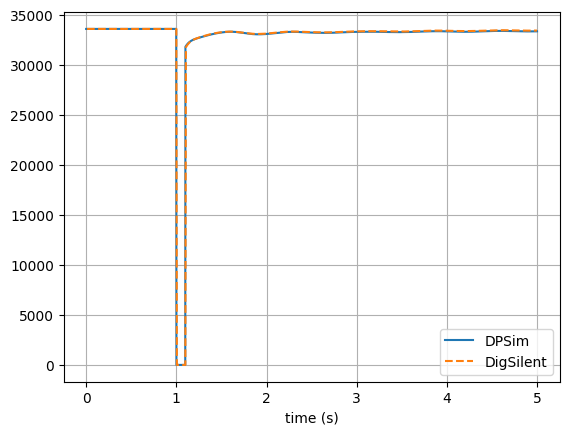

In [16]:
import matplotlib.pyplot as plt
timestep_common = 1e-3

plt.plot(ts_dpsim['Bus_0014.V'].time, ts_dpsim['Bus_0014.V'].abs().values, label='DPSim')
plt.plot(ts_powerfactory['Bus_0014'].interpolate(timestep_common).time, ts_powerfactory['Bus_0014'].interpolate(timestep_common).abs().values * 33000, '--', label='DigSilent')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
#plt.ylabel(ylabels[varname_dpsim])
plt.grid()
#plt.xlim([0.95, 1.05])
#plt.ylim([135e3, 145e3])
#plt.ylim([32e3, 36e3])
plt.show